/home/precious/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/precious/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide

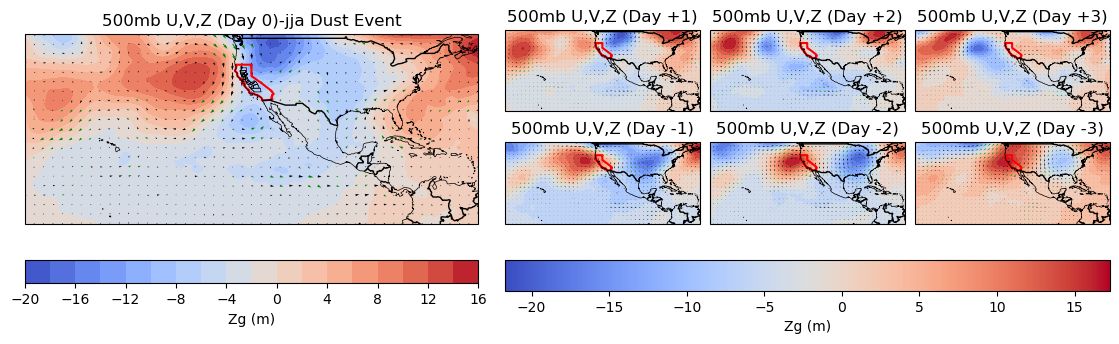

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import cartopy.feature as cfeature
from scipy.stats import ttest_ind, ttest_1samp
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable


# ---------------------------------------------------------------------
# 1) Define a function to load and process each dataset
# ---------------------------------------------------------------------
def load_and_process_data(
    z_clim_file, z_dust_file,
    u_clim_file, u_dust_file,
    v_clim_file, v_dust_file,
    lat_bounds=(0, 50), lon_bounds=(-180, -60),
    quiver_spacing=10
):
    """
    Loads the climatology and dust-event data for geopotential height (z),
    as well as u and v wind components. Then it computes:
      - Geopotential height anomalies
      - T-tests for z anomalies
      - U and V anomalies and their significance
      - Subsampled quiver data for plotting
    Returns a dictionary with all needed arrays for plotting.
    """
    # -----------------------
    # A) Load data
    # -----------------------
    climatology = xr.open_dataset(z_clim_file)
    dust_event = xr.open_dataset(z_dust_file)

    u_clim = xr.open_dataset(u_clim_file)
    u_dust = xr.open_dataset(u_dust_file)

    v_clim = xr.open_dataset(v_clim_file)
    v_dust = xr.open_dataset(v_dust_file)

    # -----------------------
    # B) Define domain and compute anomalies (Z)
    # -----------------------
    lat = climatology['latitude'].values
    lon = climatology['longitude'].values
    lat_mask = (lat >= lat_bounds[0]) & (lat <= lat_bounds[1])
    lon_mask = (lon >= lon_bounds[0]) & (lon <= lon_bounds[1])
    lat_restricted = lat[lat_mask]
    lon_restricted = lon[lon_mask]

    # Convert from geopotential (m²/s²) to geopotential height (m) by dividing by 9.8
    anomalies = (dust_event / 9.8) - (climatology / 9.8)
    mean_anomalies = anomalies.mean(dim="valid_time").sel(
        latitude=lat_restricted, longitude=lon_restricted
    )

    # If there's a pressure_level dimension, average over it
    if 'pressure_level' in mean_anomalies.dims:
        mean_anomalies_2d = mean_anomalies['z'].mean(dim='pressure_level')
    else:
        mean_anomalies_2d = mean_anomalies['z']

    # -----------------------
    # C) T-test for Z anomalies
    # -----------------------
    z_dust_data = dust_event['z'] / 9.8
    z_clim_data = climatology['z'] / 9.8

    if 'pressure_level' in z_dust_data.dims:
        z_dust_2d = z_dust_data.mean(dim='pressure_level')
        z_clim_2d = z_clim_data.mean(dim='pressure_level')
    else:
        z_dust_2d = z_dust_data
        z_clim_2d = z_clim_data

    t_stat, p_values_z = ttest_ind(
        z_dust_2d.values,
        z_clim_2d.values,
        axis=0,
        equal_var=False,
        nan_policy='omit'
    )

    # Turn p-values into an xarray
    p_values_z_da = xr.DataArray(
        p_values_z,
        dims=['latitude', 'longitude'],
        coords={'latitude': z_dust_2d.latitude.values,
                'longitude': z_dust_2d.longitude.values}
    )
    # Restrict domain
    p_values_z_restricted = p_values_z_da.sel(
        latitude=lat_restricted, longitude=lon_restricted
    )

    # -----------------------
    # D) T-tests for u, v anomalies
    # -----------------------
    # difference between dust and clim
    u_diff = (u_dust['u'] - u_clim['u']).sel(
        latitude=lat_restricted, longitude=lon_restricted
    )
    v_diff = (v_dust['v'] - v_clim['v']).sel(
        latitude=lat_restricted, longitude=lon_restricted
    )

    # If there's a pressure_level dimension, average over it
    if 'pressure_level' in u_diff.dims:
        u_diff = u_diff.mean(dim='pressure_level')
    if 'pressure_level' in v_diff.dims:
        v_diff = v_diff.mean(dim='pressure_level')

    # Mean anomalies
    u_anomalies = u_diff.mean(dim='valid_time').squeeze()
    v_anomalies = v_diff.mean(dim='valid_time').squeeze()

    # 1-sample t-tests vs. 0
    t_stat_u, p_values_u = ttest_1samp(u_diff.values, popmean=0.0, axis=0, nan_policy='omit')
    t_stat_v, p_values_v = ttest_1samp(v_diff.values, popmean=0.0, axis=0, nan_policy='omit')

    wind_sig_mask = (p_values_u < 0.05) & (p_values_v < 0.05)

    wind_sig_mask_da = xr.DataArray(
        wind_sig_mask,
        dims=['latitude', 'longitude'],
        coords={'latitude': u_diff.latitude.values,
                'longitude': u_diff.longitude.values}
    )

    # -----------------------
    # E) Prepare quiver data
    # -----------------------
    lon2d, lat2d = np.meshgrid(lon_restricted, lat_restricted)
    lon_quiver = lon2d[::quiver_spacing, ::quiver_spacing]
    lat_quiver = lat2d[::quiver_spacing, ::quiver_spacing]
    u_quiver = u_anomalies.values[::quiver_spacing, ::quiver_spacing]
    v_quiver = v_anomalies.values[::quiver_spacing, ::quiver_spacing]
    wind_sig_mask_quiver = wind_sig_mask_da.values[::quiver_spacing, ::quiver_spacing]

    # Return a dictionary with all data needed for plotting
    return {
        "mean_anomalies_2d": mean_anomalies_2d,
        "p_values_z_restricted": p_values_z_restricted,
        "lat2d": lat2d,
        "lon2d": lon2d,
        "u_anomalies": u_anomalies,
        "v_anomalies": v_anomalies,
        "wind_sig_mask_da": wind_sig_mask_da,
        "lon_quiver": lon_quiver,
        "lat_quiver": lat_quiver,
        "u_quiver": u_quiver,
        "v_quiver": v_quiver,
        "wind_sig_mask_quiver": wind_sig_mask_quiver
    }


# ---------------------------------------------------------------------
# 2) Load each dataset: Onset, Box 1–6
# ---------------------------------------------------------------------

# Shapefiles (change paths if needed)
california_shapefile = "california_shapefile.shp"
central_valley_shapefile = "central_valley_counties.shp"

# Onset (Day 0)
data_onset = load_and_process_data(
    z_clim_file="z_clim.nc",
    z_dust_file="z_jja_lag0.nc",
    u_clim_file="u_clim_jja.nc",
    u_dust_file="u_jja_lag0.nc",
    v_clim_file="v_clim_jja.nc",
    v_dust_file="v_jja_lag0.nc",
    lat_bounds=(0, 50),
    lon_bounds=(-180, -60),
    quiver_spacing=10
)

# Box 1 (Lead 1)
data_box1 = load_and_process_data(
    z_clim_file="z_clim.nc",
    z_dust_file="z_jja_lead1.nc",
    u_clim_file="u_clim_jja.nc",
    u_dust_file="u_jja_lead1.nc",
    v_clim_file="v_clim_jja.nc",
    v_dust_file="v_jja_lead1.nc"
)

# Box 2 (Lead 2)
data_box2 = load_and_process_data(
    z_clim_file="z_clim.nc",
    z_dust_file="z_jja_lead2.nc",
    u_clim_file="u_clim_jja.nc",
    u_dust_file="u_jja_lead2.nc",
    v_clim_file="v_clim_jja.nc",
    v_dust_file="v_jja_lead2.nc"
)

# Box 3 (Lead 3)
data_box3 = load_and_process_data(
    z_clim_file="z_clim.nc",
    z_dust_file="z_jja_lead3.nc",
    u_clim_file="u_clim_jja.nc",
    u_dust_file="u_jja_lead1.nc",  # <-- confirm if correct
    v_clim_file="v_clim_jja.nc",
    v_dust_file="v_jja_lead3.nc"
)

# Box 4 (Lag 1)
data_box4 = load_and_process_data(
    z_clim_file="z_clim.nc",
    z_dust_file="z_jja_lag1.nc",
    u_clim_file="u_clim_jja.nc",
    u_dust_file="u_jja_lag1.nc",
    v_clim_file="v_clim_jja.nc",
    v_dust_file="v_jja_lag1.nc"
)

# Box 5 (Lag 2)
data_box5 = load_and_process_data(
    z_clim_file="z_clim.nc",
    z_dust_file="z_jja_lag2.nc",
    u_clim_file="u_clim_jja.nc",
    u_dust_file="u_jja_lag2.nc",
    v_clim_file="v_clim_jja.nc",
    v_dust_file="v_jja_lag2.nc"
)

# Box 6 (Lag 3)
data_box6 = load_and_process_data(
    z_clim_file="z_clim.nc",
    z_dust_file="z_jja_lag3.nc",
    u_clim_file="u_clim_jja.nc",
    u_dust_file="u_jja_lag3.nc",
    v_clim_file="v_clim_jja.nc",
    v_dust_file="v_jja_lag3.nc"
)


# ---------------------------------------------------------------------
# 3) Plotting with Nested GridSpec
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# Outer GridSpec: 1 row, 2 columns
outer_gs = gridspec.GridSpec(
    1, 2,
    width_ratios=[1.5, 2.0],  # Left vs. right panel widths
    wspace=0.05
)

# ---------------------------
# A) Helper function for plotting
# ---------------------------
def plot_map(ax, data_dict, shapefile1=None, shapefile2=None, title=""):
    """
    Plots:
     - filled contours of mean_anomalies_2d
     - significance hatching from p_values_z_restricted
     - quiver (green if significant, black if not)
     - optional shapefiles
    """
    mean_anoms = data_dict["mean_anomalies_2d"]
    pvals = data_dict["p_values_z_restricted"]
    lon2d = data_dict["lon2d"]
    lat2d = data_dict["lat2d"]
    lon_q = data_dict["lon_quiver"]
    lat_q = data_dict["lat_quiver"]
    u_q = data_dict["u_quiver"]
    v_q = data_dict["v_quiver"]
    wind_mask = data_dict["wind_sig_mask_quiver"]

    # Filled contours
    contour_plot = ax.contourf(
        lon2d, lat2d, mean_anoms,
        levels=20, cmap="coolwarm",
        transform=ccrs.PlateCarree()
    )

    # Significance hatching
    ax.contourf(
        lon2d, lat2d, pvals,
        levels=[0, 0.05, 1],
        colors="none",
        hatches=["", "///"],
        transform=ccrs.PlateCarree()
    )

    # Quiver
    sig_inds = np.where(wind_mask)
    nonsig_inds = np.where(~wind_mask)
    ax.quiver(
        lon_q[sig_inds],
        lat_q[sig_inds],
        u_q[sig_inds],
        v_q[sig_inds],
        scale=200, width=0.002, color="green",
        transform=ccrs.PlateCarree()
    )
    ax.quiver(
        lon_q[nonsig_inds],
        lat_q[nonsig_inds],
        u_q[nonsig_inds],
        v_q[nonsig_inds],
        scale=200, width=0.002, color="black",
        transform=ccrs.PlateCarree()
    )

    # Add shapefiles if provided
    if shapefile1:
        ax.add_feature(
            ShapelyFeature(
                Reader(shapefile1).geometries(),
                ccrs.PlateCarree(),
                edgecolor='red', facecolor='none', linewidth=1.5
            )
        )
    if shapefile2:
        ax.add_feature(
            ShapelyFeature(
                Reader(shapefile2).geometries(),
                ccrs.PlateCarree(),
                edgecolor='black', facecolor='none', linewidth=0.5
            )
        )

    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.set_extent([-180, -60, 0, 50], crs=ccrs.PlateCarree())
    ax.set_title(title)

    return contour_plot


# ---------------------------
# B) Left panel: Onset
# ---------------------------
ax_onset = fig.add_subplot(outer_gs[0, 0], projection=ccrs.PlateCarree())
onset_contour = plot_map(
    ax_onset,
    data_dict=data_onset,
    shapefile1=california_shapefile,
    shapefile2=central_valley_shapefile,
    title="500mb U,V,Z (Day 0)-jja Dust Event"
)

# Colorbar for the Onset panel
cb_onset = fig.colorbar(
    onset_contour, ax=ax_onset,
    orientation='horizontal',
    fraction=0.07, pad=0.08
)
cb_onset.set_label("Zg (m)")

# ---------------------------
# C) Right panel: 2×3 subplots for Boxes
# ---------------------------
sub_gs = gridspec.GridSpecFromSubplotSpec(
    2, 3,
    subplot_spec=outer_gs[0, 1],
    wspace=0.05,
    hspace=-0.6
)

# Create Axes
ax_box1 = fig.add_subplot(sub_gs[0, 0], projection=ccrs.PlateCarree())
ax_box2 = fig.add_subplot(sub_gs[0, 1], projection=ccrs.PlateCarree())
ax_box3 = fig.add_subplot(sub_gs[0, 2], projection=ccrs.PlateCarree())
ax_box4 = fig.add_subplot(sub_gs[1, 0], projection=ccrs.PlateCarree())
ax_box5 = fig.add_subplot(sub_gs[1, 1], projection=ccrs.PlateCarree())
ax_box6 = fig.add_subplot(sub_gs[1, 2], projection=ccrs.PlateCarree())

# Plot each box
cf_box1 = plot_map(ax_box1, data_box1, title="500mb U,V,Z (Day +1)",shapefile1=california_shapefile)
cf_box2 = plot_map(ax_box2, data_box2, title="500mb U,V,Z (Day +2)",shapefile1=california_shapefile)
cf_box3 = plot_map(ax_box3, data_box3, title="500mb U,V,Z (Day +3)",shapefile1=california_shapefile)
cf_box4 = plot_map(ax_box4, data_box4, title="500mb U,V,Z (Day -1)",shapefile1=california_shapefile)
cf_box5 = plot_map(ax_box5, data_box5, title="500mb U,V,Z (Day -2)",shapefile1=california_shapefile)
cf_box6 = plot_map(ax_box6, data_box6, title="500mb U,V,Z (Day -3)",shapefile1=california_shapefile)

# For a shared color scale among boxes, find global min/max
# across the six data_box dicts if needed. For now, let's just base it on box1
vmin = np.nanmin(data_box1["mean_anomalies_2d"].values)
vmax = np.nanmax(data_box1["mean_anomalies_2d"].values)
# (In practice, you'd do something like
#   all_data_vals = np.concatenate([data_box1["mean_anomalies_2d"].values.ravel(),
#                                   data_box2["mean_anomalies_2d"].values.ravel(),
#                                   ...
#                                  ])
#   vmin, vmax = np.nanmin(all_data_vals), np.nanmax(all_data_vals)
#)

sm = ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

cbar_boxes = fig.colorbar(
    sm,
    ax=[ax_box1, ax_box2, ax_box3, ax_box4, ax_box5, ax_box6],
    orientation='horizontal',
    fraction=0.07,
    pad=0.08
)
cbar_boxes.set_label("Zg (m)")

plt.savefig("jja-dust.png", dpi=300, bbox_inches='tight')
plt.show()


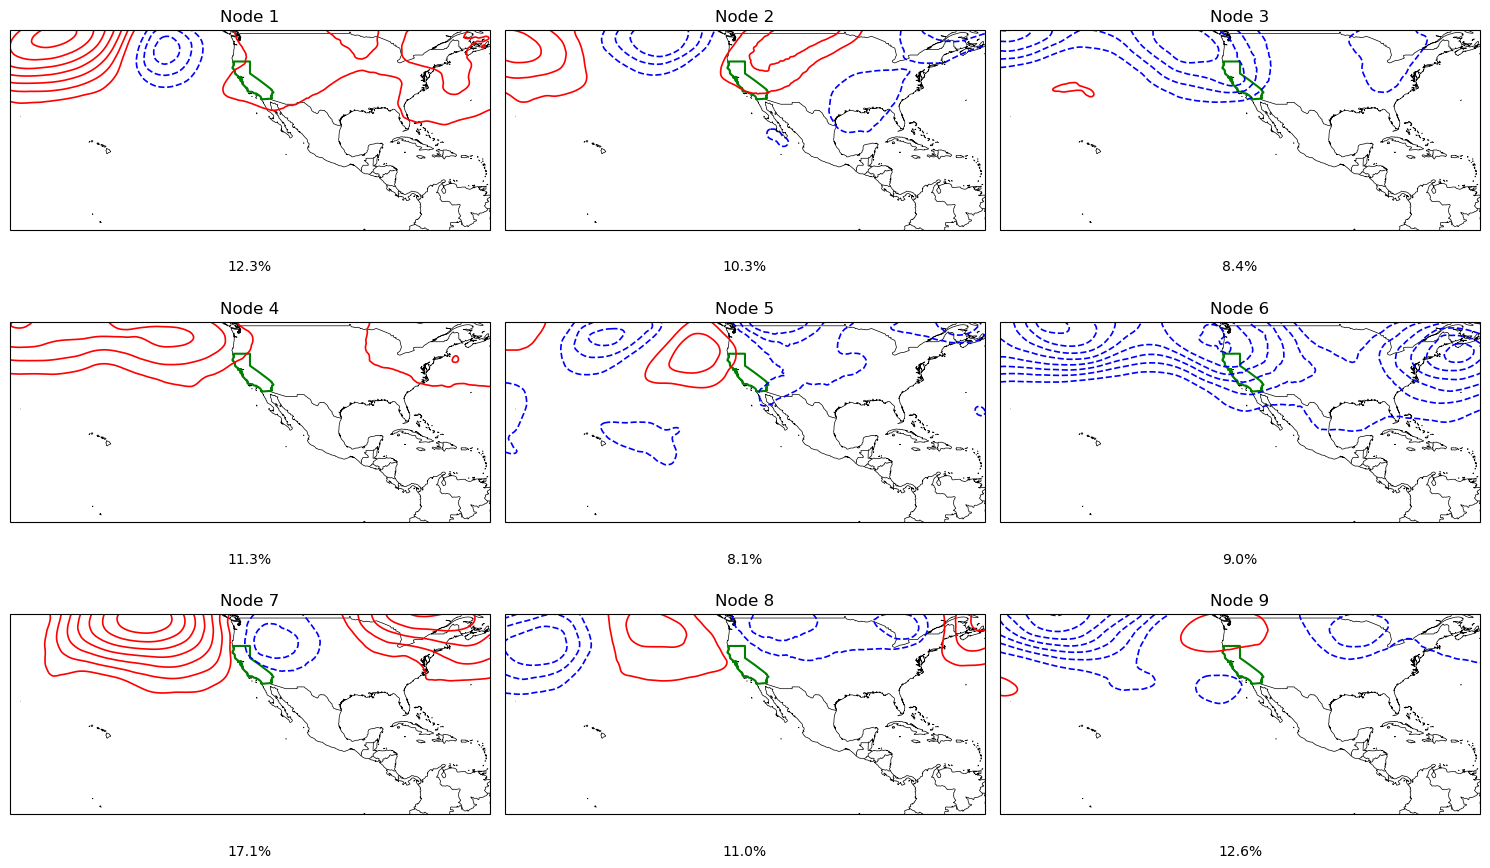

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import somoclu  # Import the somoclu module

# --------------------------------------------------
# Define the path to your California shapefile
# --------------------------------------------------
california_shapefile = "california_shapefile.shp"  # Update the path as needed

# --------------------------------------------------
# 1. Load the datasets and select the 500-hPa field
# --------------------------------------------------
# Load climatology and dust event geopotential data
climatology = xr.open_dataset("z_clim.nc")
dust_event = xr.open_dataset("z_jja_lag0.nc")

# Convert geopotential (m^2/s^2) to geopotential height (m)
z_clim = climatology['z'] / 9.8
z_dust = dust_event['z'] / 9.8

# If there is a pressure_level dimension, select the 500-hPa level.
if 'pressure_level' in z_clim.dims:
    z_clim_500 = z_clim.sel(pressure_level=500)
    z_dust_500 = z_dust.sel(pressure_level=500)
else:
    z_clim_500 = z_clim
    z_dust_500 = z_dust

# Compute the daily 500-hPa anomalies: (dust event – climatology)
anomalies = z_dust_500 - z_clim_500

# --------------------------------------------------
# 2. Restrict to the geographic region of interest
#    (e.g. longitudes from –180 to –60 and latitudes from 0 to 50)
# --------------------------------------------------
lat_all = anomalies.latitude.values
lon_all = anomalies.longitude.values

lat_mask = (lat_all >= 0) & (lat_all <= 50)
lon_mask = (lon_all >= -180) & (lon_all <= -60)
anomalies_restricted = anomalies.sel(latitude=lat_all[lat_mask],
                                     longitude=lon_all[lon_mask])

lat_vals = anomalies_restricted.latitude.values
lon_vals = anomalies_restricted.longitude.values

# --------------------------------------------------
# 3. Prepare the data for SOM clustering
#    Each daily anomaly field is flattened into a 1D vector.
# --------------------------------------------------
# data_array has shape (ntime, nlat, nlon)
data_array = anomalies_restricted.values  
ntime, nlat, nlon = data_array.shape

# Flatten the spatial dimensions so that each day becomes a 1D vector.
data_flat = data_array.reshape(ntime, nlat * nlon)

# --------------------------------------------------
# 4. Run the SOM clustering (3×4 grid; 12 nodes) using somoclu
# --------------------------------------------------
# Define the SOM grid dimensions.
n_rows, n_columns = 3, 3  # 3 rows x 4 columns = 12 nodes

# Instantiate the SOM (note that somoclu expects the number of columns first)
som = somoclu.Somoclu(n_columns, n_rows, maptype="planar")

# Set the random seed for reproducibility.
np.random.seed(42)

# Train the SOM by passing the data (with 1000 epochs).
som.train(data_flat, epochs=1000)

# Retrieve the best matching units (BMUs) for each input.
# Each BMU is given as (row, col)
bmus = som.bmus

# Convert the 2D BMU coordinates into a single label:
# label = row * n_columns + col, yielding values 0...11.
labels = bmus[:, 0] * n_columns + bmus[:, 1]

# --------------------------------------------------
# 5. Compute composite anomalies and frequency for each node
# --------------------------------------------------
composites = {}    # To store the composite (mean anomaly) per node.
frequencies = {}   # To store the frequency (%) for each node.

for node in range(n_rows * n_columns):  # for each of the 12 nodes
    mask = (labels == node)
    count = np.sum(mask)
    if count > 0:
        # Compute the composite (mean anomaly) for days assigned to this node.
        composite = np.nanmean(data_array[mask, :, :], axis=0)
    else:
        # If no day falls into this node, fill with NaNs.
        composite = np.full((nlat, nlon), np.nan)
    composites[node] = composite
    frequencies[node] = count / ntime * 100

# --------------------------------------------------
# 6. Prepare unified contour levels
#     Define a single set of contour levels (every 25 m) spanning the full anomaly range.
# --------------------------------------------------
max_abs = np.nanmax(np.abs(data_array))
max_val = np.ceil(max_abs / 25) * 25  # round up to the nearest 25 m
levels = np.arange(-max_val, max_val + 25, 25)

# Create a 2D meshgrid for plotting.
lon2d, lat2d = np.meshgrid(lon_vals, lat_vals)

# --------------------------------------------------
# 7. Plot the SOM composites
# --------------------------------------------------
fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})
#fig.suptitle("Composite 500-hPa Geopotential Height Anomalies by SOM Node", fontsize=16)

for node in range(n_rows * n_columns):
    row = node // n_columns
    col = node % n_columns
    ax = axes[row, col]
    
    # Add geographic features.
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    # Add the California shapefile with a green outline.
    ax.add_feature(
        ShapelyFeature(
            Reader(california_shapefile).geometries(),
            ccrs.PlateCarree(),
            edgecolor='green', facecolor='none', linewidth=1.5
        )
    )
    
    ax.set_extent([-180, -60, 0, 50], crs=ccrs.PlateCarree())
    
    comp = composites[node]
    # Only attempt to plot if the composite contains valid data.
    if not np.all(np.isnan(comp)):
        # Separate unified levels into negative and positive levels.
        neg_levels = levels[levels < 0]
        pos_levels = levels[levels > 0]
        
        # Plot negative anomalies in blue.
        if neg_levels.size > 0:
            ax.contour(lon2d, lat2d, comp, levels=neg_levels,
                       colors='blue', linewidths=1.2)
        
        # Plot positive anomalies in red.
        if pos_levels.size > 0:
            ax.contour(lon2d, lat2d, comp, levels=pos_levels,
                       colors='red', linewidths=1.2)
    
    # Display the frequency (%) in the lower part of each subplot.
    freq = frequencies[node]
    ax.text(0.5, -0.15, f"{freq:.1f}%", transform=ax.transAxes,
            ha='center', va='top', fontsize=10, color='k')
    
    # Add a title for the SOM node.
    ax.set_title(f"Node {node+1}", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("jja_som.png", dpi=300)
plt.show()
